In [1]:
import time
import astropy
import itertools

import numpy             as np
import pylab             as pl
import matplotlib.pyplot as plt
import astropy.units     as u

from   astropy.cosmology import FlatLambdaCDM
from   IPython.display   import YouTubeVideo
from   tools.flops       import flops

In [2]:
%matplotlib notebook

plt.style.use('dark_background')

# DESI y la supercomputadora más rápida de Occidente

Entender _cómo_ los 30 millones de galaxias estudiadas por DESI se formaron realmente en el Universo es difícil, realmente difícil. De hecho, es tan difícil que DESI explota [Summit](https://www.olcf.ornl.gov/summit/), la supercomputadora más rápida del mundo en el Laboratorio Nacional de Oak Ridge para calcular cómo debería verse la distribución de las galaxias según el tipo de Energía oscura:

<img src="images/summit.jpg" alt="Drawing" style="width: 800px;"/>

Con un costo de construcción de 325 millones de dólares, Summit es capaz de calcular operaciones de suma y multiplicación $1.486 \times 10^{17}$ por segundo, equivalente a $1.486 \times 10^{11}$ MegaFlops o MFLOPS. A modo de comparación, veamos qué proporciona Binder (necesitará un poco de paciencia, tal vez deje esto para más adelante):

In [3]:
_ = flops()



   FLOPS Python Program (Double Precision), V2.0 18 Dec 1992


   Module     Error        RunTime      MFLOPS

                            (usec)

     1      1.3358e-12      0.2232     62.7334

     2      1.9984e-13      0.1050     66.6381

     3     -2.4480e-14      0.2663     63.8491



¡Así que Summit es al menos mil millones de veces más poderoso! Con Summit, podemos resolver los detalles más finos de la distribución de _materia oscura_ que trazan todas las galaxias:

<img src="images/abacus.png" alt="Drawing" style="width: 600px;"/>

Aquí, las regiones más brillantes significan las regiones más densas de materia oscura en el Universo, en las que esperamos encontrar más galaxias. El siguiente video muestra que hemos observado esta estructura predicha en la distribución de galaxias reales observadas con experimentos antes de DESI:

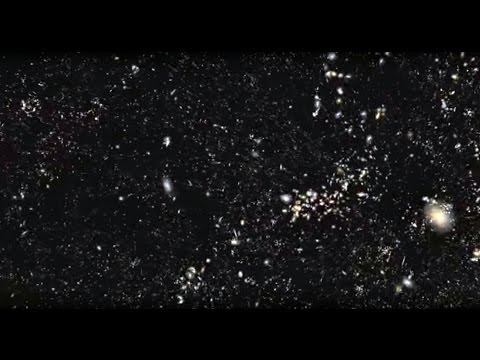

In [3]:
YouTubeVideo('08LBltePDZw', width=800, height=400)

[La materia oscura](https://en.wikipedia.org/wiki/Dark_matter#:~:text=Dark%20matter%20is%20a%20form,%E2%88%9227%20kg%2Fm3.) Es un elemento omnipresente en nuestro Universo, lo que constituye el 25% de la densidad (de energía) total. Con la Energía Oscura y los átomo comunes (materioa bariónica) formando el resto. No sabemos casi nada sobre la materia oscura, más allá de su atracción gravitacional a otra materia y luz en el Universo.

Afortunadamente, las ecuaciones que describen la evolución de la materia oscura, a differencia de la [formación compleja de galaxias](https://www.space.com/15680-galaxies.html), son relativamente simples para el Universo en el que vivimos. Todo lo que se requiere es rastrear la atracción gravitacional de las partículas de materia oscura (en un Universo en expansión).

Podemos predecir la evolución de la materia oscura muestreando la fuerza gravitacional, la velocidad y la posición con un conjunto de partículas (ficticias) que representan cada una un "grupo" de materia oscura con una masa total. Por supuesto, esto significa que no podemos resolver la distribución de la materia oscura dentro de estas regiones del tamaño de grupos, pero solo la distribución entre aglomerados conduce a la estructura que puede verse arriba. Con Summit, el grupo más pequeño que podemos resolver no está lejos de la masa del 'halo' de materia oscura que rodea el centro de nuestra propia [Vía Láctea](https://www.nasa.gov/feature/goddard/2019/¿qué-pesa-la-vía-láctea-hubble-y-gaia-investiga):

<img src="images/MilkyWay.jpg" alt="Drawing" style="width: 1000px;"/>

Para empezar, colocaremos inicialmente un conjunto de grupos en posiciones aleatorias dentro de un cubo 3D y les daremos velocidades iniciales cero. Las velocidades se generarán en momentos posteriores, ya que la atracción gravitacional ($1/r^2$) de una partícula hacia todas las demás provoca una aceleración neta.

In [4]:
def init_dof(npt=1):
  #  Create a set of particles at random positions in a box, which will soon predict the distribution of dark matter 
  #  as we see above.
  xs     = np.random.uniform(0., 1., npt)
  ys     = np.random.uniform(0., 1., npt)
  zs     = np.random.uniform(0., 1., npt)

  pos    = np.vstack((xs, ys, zs)).T
  vel    = np.zeros_like(pos)              

  return  pos, vel

La fuerza gravitacional experimentada por cada partícula de materia oscura es [Newton](https://en.wikipedia.org/wiki/Isaac_Newton) $F = \frac{GmM}{r^2} \hat r$ con la que puede estar familiarizado. Solo necesitamos hacer un trabajo minucioso en la contabilidad requerida para calcular la fuerza total experimentada por una partícula debido a todas las demás:

In [5]:
def g_at_particle(index, pos, mass, epsilon=1.0, doimages=True):
    # eqn. (10) of http://www.skiesanduniverses.org/resources/KlypinNbody.pdf.
    indices = np.arange(len(pos))
    rest    = pos[indices != index,:]

    # Here epsilon is a fudge factor to stop a blow up of the gravitational force at zero distance.     
    result  = mass * np.sum((rest - pos[index]) / ((rest - pos[index])**2. + epsilon**2.)**(3./2.), axis=0)

    if doimages:
        # Our simulation assumes periodic boundary conditions, so for the acceleration of each particle, there's a 
        # corresponding acceleration due to the image of the particle produced by applying periodic shifts to its
        # position.
        shift  = np.array([-1, 0, 1]) 
        images = []

        for triple in itertools.product(shift, repeat=3):
            images.append(triple)
    
        images.remove((0, 0, 0))
    
        images = np.array(images)
    
        for image in images:
            result += mass * np.sum((rest + image - pos[index]) / ((rest + image - pos[index])**2. + epsilon**2.)**(3./2.), axis=0)

    return  result

En un experimento notable en 1941, Erik Holmberg utilizó el hecho de que el brillo de la luz decae con la distancia al mismo ritmo ($1/r^2$) que la gravedad. Para calcular la fuerza total sobre una 'partícula' en su 'simulación', Erik colocó una bombilla en la posición de cada partícula y calculó la fuerza efectiva sobre una partícula dada midiendo el brillo total en cada punto. La siguiente figura ilustra esta idea. ¡Intente ejecutar la siguiente celda varias veces! Obtendrá un diseño aleatorio diferente de bombillas cada vez.

<IPython.core.display.Javascript object>


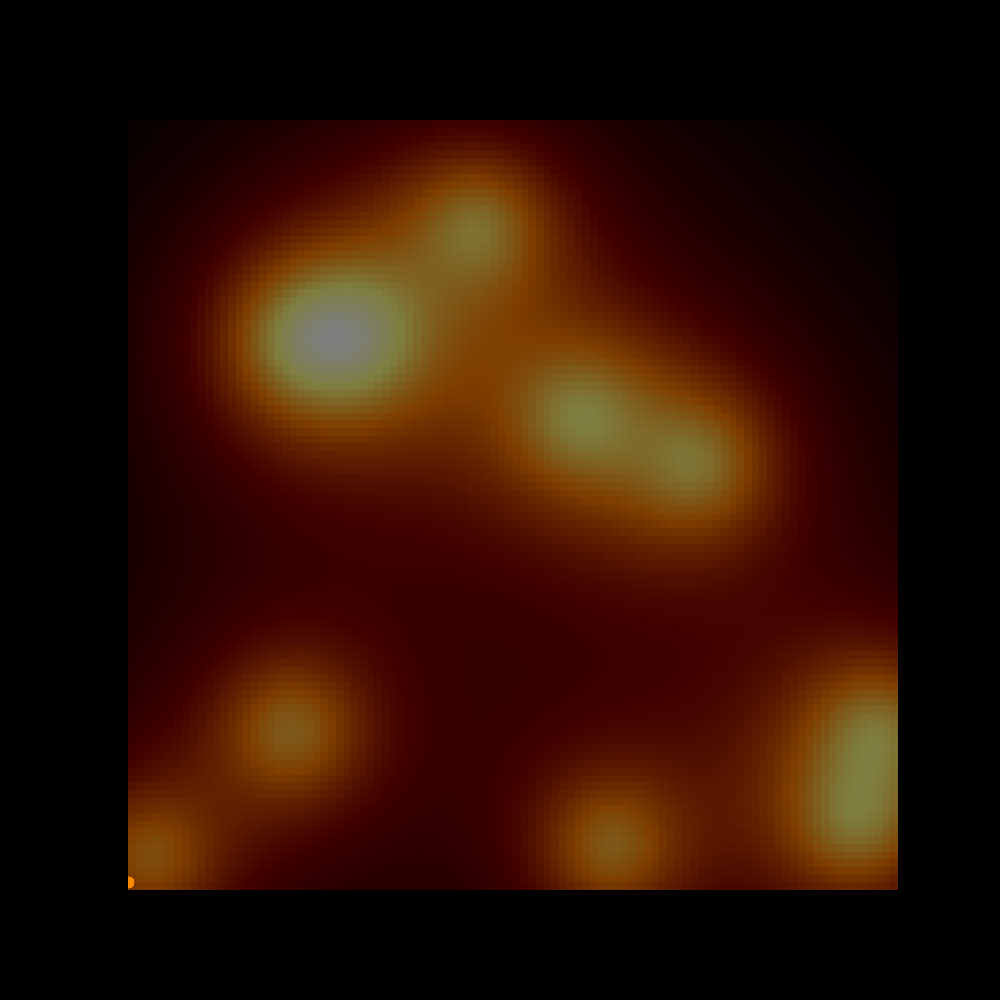

(0.0, 1.0, 0.0, 1.0)

In [10]:
fig, ax   = plt.subplots(1, 1, figsize=(5,5))

xmin, xmax, ymin, ymax = (0., 1., 0., 1.)

N         = 100
xx, yy    = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
epsilon   = 0.1

weights   = np.zeros_like(xx) 

pos, vel  = init_dof(npt=10)

for par in pos:
  weights += 1. / ((xx - par[0])**2 + (yy - par[1])**2 + epsilon**2.)

ax.imshow(weights, extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.afmhot, alpha=0.5, origin='lower')

ax.plot(xx[:,0], xx[:,1], '.', c='darkorange', alpha=0.75)
ax.tick_params(labelbottom=False, labelleft=False)  

ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)

plt.axis('off')

Este trabajo fue el concepto original de las simulaciones gravitacionales de 'n-cuerpos' que se describen aquí. ¡Es casi criminal que solo 118 autores hayan hecho referencia a esta innovadora idea!

<img src="images/Holmberg.png" alt="Drawing" style="width: 800px;"/>

Hoy, dadas las mini supercomputadoras que tenemos a menudo al alcance de la mano, podemos determinar la distribución final de la materia oscura con mayor precisión con computadoras que con bombillas. Evolucionando una distribución homogénea inicial (una distribución casi uniforme de aglomeraciones de materia oscura, como el universo produjo en el Big Bang) bajo la gravedad, podemos predecir con precisión la ubicación de las galaxias (los lugares donde se forman los grupos de materia oscura más grandes).
 
Para hacer esto, solo necesitamos calcular la aceleración de cada partícula en una serie de pasos de tiempo y actualizar la velocidad y la posición de acuerdo con la aceleración que experimenta la partícula. Habrá experimentado esto como la sensación que siente cuando un automóvil dobla una esquina o acelera.

In [11]:
# We'll sample the equations of motion in discrete time steps. 
dt         = 1.e-2
nsteps     = 500

timesteps  = np.linspace(0.0, nsteps * dt, nsteps)
dt         = np.diff(timesteps)[0]

mass       = 0.25

Ahora simplemente tenemos que ejecutar la simulación,

<IPython.core.display.Javascript object>


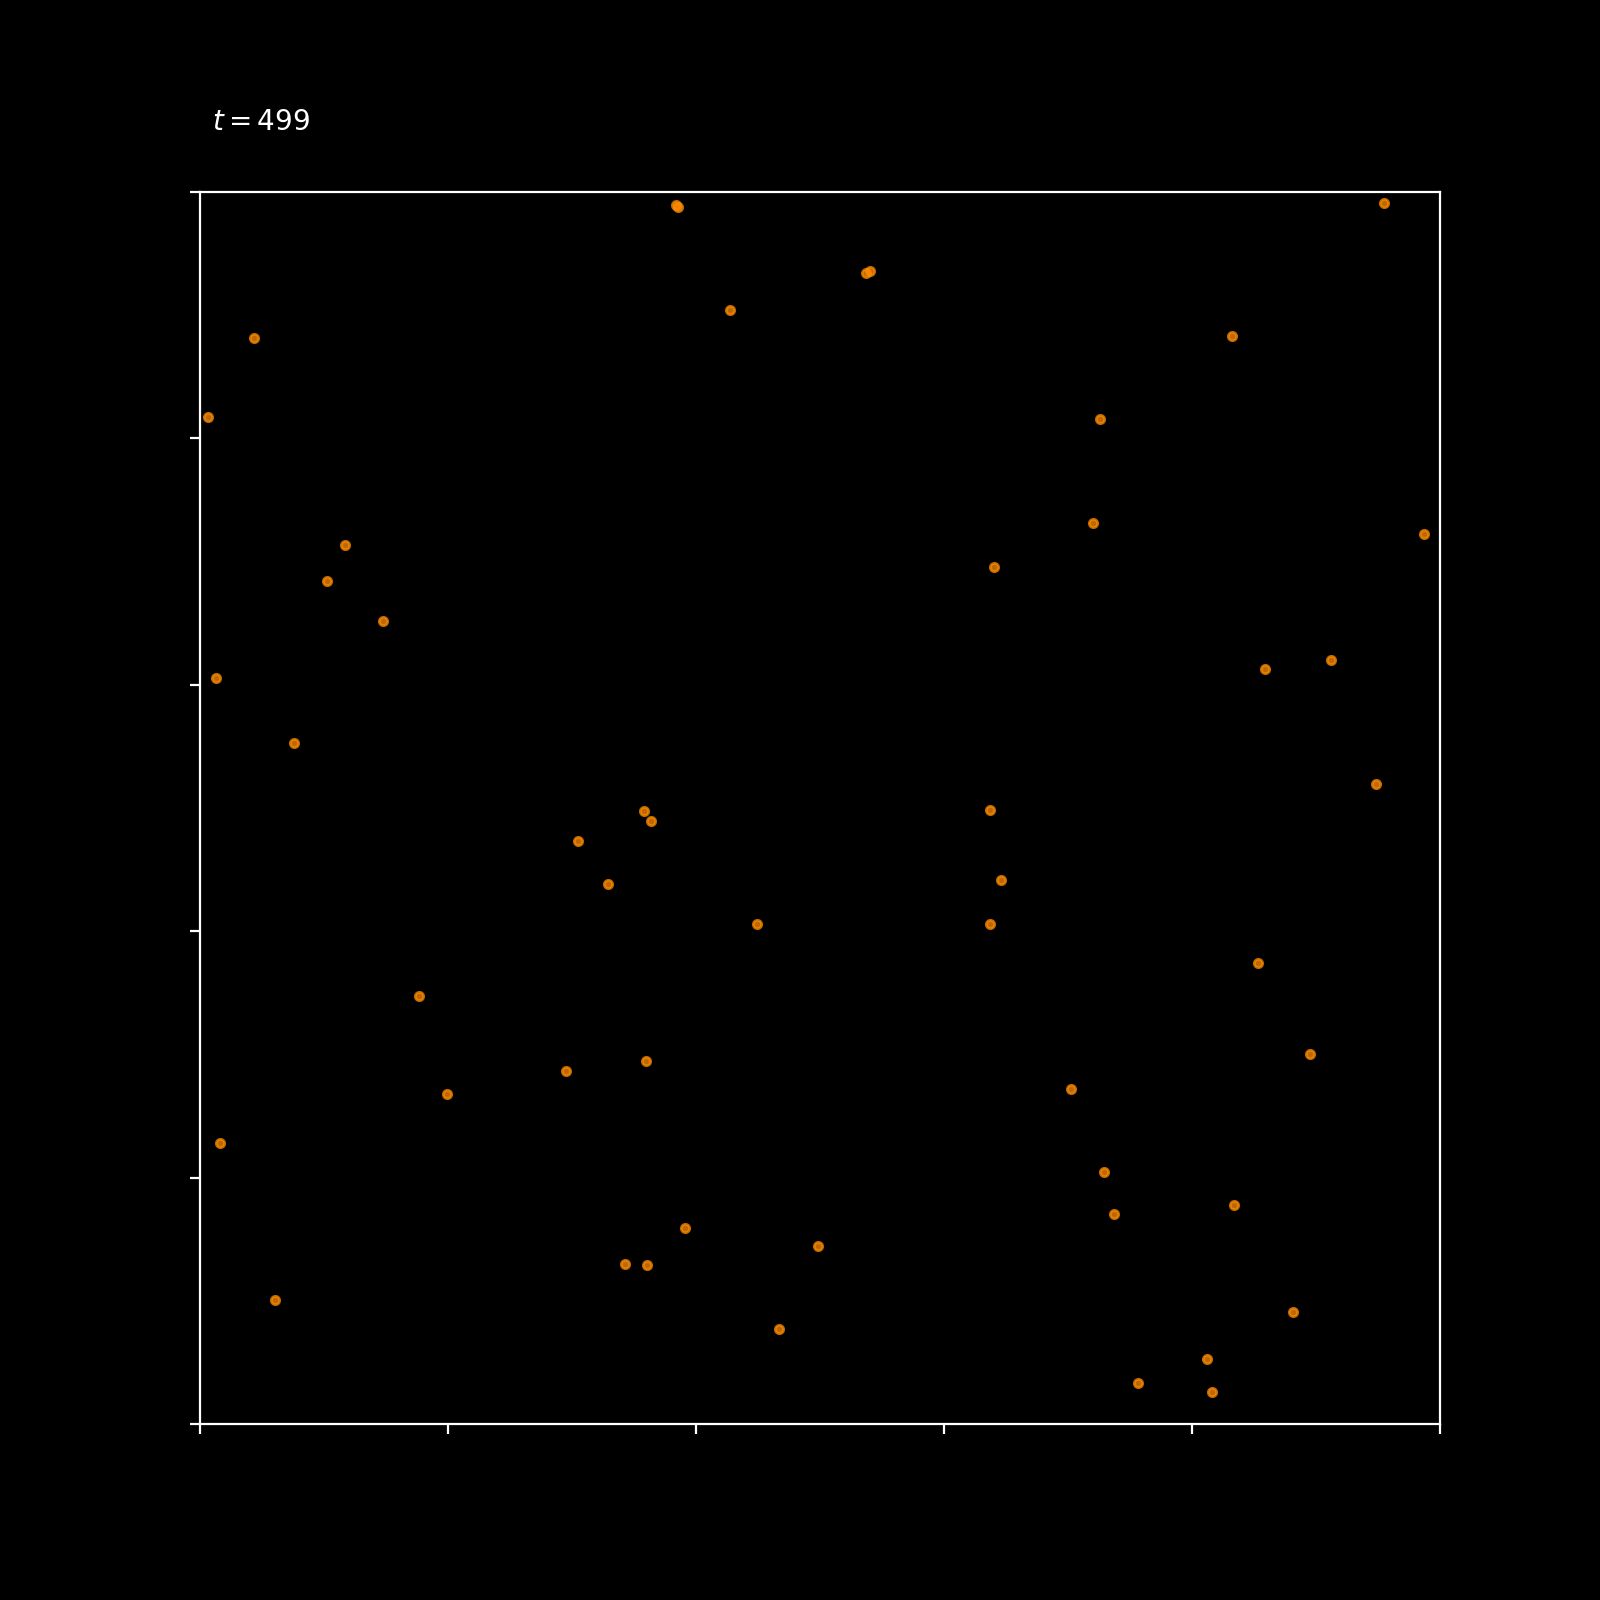

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.tick_params(labelbottom=False, labelleft=False)  

plt.axis('off')

# Reinitialise particles.
pos, vel = init_dof(npt=50)

for index_in_timestep , time in enumerate(timesteps):    
    pl.cla()
    
    ax.text(0.01, 1.05, '$t={:d}$'.format(index_in_timestep), transform=ax.transAxes)

    dvel                        = np.zeros_like(vel)
    dpos                        = np.zeros_like(pos)
    
    for index_in_particle, _ in enumerate(pos):
        g_X                     = g_at_particle(index_in_particle, pos, mass, doimages=True)
        
        # Update velocities. 
        dvel[index_in_particle] = dt * g_X 
        
        # Update positions.
        dpos[index_in_particle] = dt * vel[index_in_particle]           
        
    vel += dvel
    pos += dpos
    
    # Our simulation has periodic boundaries, if you go off one side you come back on the other!
    pos = pos % 1.
    
    ax.plot(pos[:,0], pos[:,1], '.', c='darkorange', alpha=0.75)
    
    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)
    
    fig.canvas.draw()

¡Intenta jugar con la configuración! Sin embargo, más de 100 partículas no funcionarán muy bien. Con la configuración predeterminada, encontrarás que las partículas tienden a caer en uno o dos cúmulos en poco tiempo. Esto se debe al arrastre que aplicamos. El arrastre simula el efecto que tiene el universo en expansión sobre las partículas reales de materia oscura, que es alentarlas y hacer que se agrupen. Estos grupos se conocen como halos y forman criaderos galácticos donde el gas puede acumularse para formar nuevas estrellas y galaxies. Ahora, cuando DESI ejecuta grandes simulaciones, como las que se ejecutan en Summit, se resuelve un total de ~ 48 _billones de_ partículas. ¡No intentes esto aquí! Pero los resultados son realmente extraordinarios (¡salte a 6 minutos y 45 segundos si está impaciente por ver el resultado!):

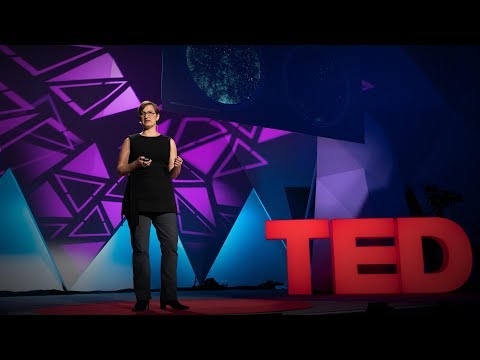

In [13]:
YouTubeVideo('LQMLFryA_7k', width=800, height=400)

Con este gran éxito, viene una responsabilidad adicional. Esta informática de alto rendimiento, si bien es fantástica para DESI y la ciencia, ahora tiene una [huella de carbono](https://en.wikipedia.org/wiki/Carbon _huella) comparable a la [industria mundial de las aerolíneas](https: / /www.hpcwire.com/solution_ content / ibm / cross-industry / five-tips-to-reduce-your-hpc-carbon-footprint /) y consume la misma cantidad de electricidad que el país de Irán (82 ¡un millón de personas!).

Más preocupante aún, esto pronto crecerá del 2% del consumo de energía del mundo a ~ 30%. ¡Una tarifa extraordinaria!

Afortunadamente, Summit también se encuentra entre las supercomputadoras más ecológicas. Su valor de 14,7 GFlops / vatio significa una clasificación número 1 en la [lista global Green 500 2019](https://www.top500.org/lists/green500/2019/06/). ¡Mejor suerte el año que viene, E.U.!

<img src="images/Amazon.jpg" alt="Drawing" style="width: 800px;"/>